In [1]:
try :
    # % tensorflow_version only exists in Colab .
    % tensorflow_version 2. x
except Exception :
    pass

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import stockstats
import os
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from lib.rens import rens

In [12]:
def create_dataset(dataset, true_price, look_back = 1, look_forward = 1):
      
    # MinMax
    #min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    #dataset = min_max_scaler.fit_transform(dataset)
    
    # Standarised
    sc = preprocessing.StandardScaler()
    dataset = sc.fit_transform(dataset)

    
    #print(dataset)
    lookback = look_back
    datax = []
    datay = []
    
    for i,v in enumerate(dataset):
        if i > lookback + look_forward:
            datax.append([dataset[i-j] for j in range(lookback, 0, -1)])
            datay.append([true_price[i-j] for j in range(lookback+look_forward, lookback, -1)])    
    
    datax = np.array(datax)
    datay = np.array(datay)
    
    # Standardize y data for å skille dem fra hverandre
    mean = datay.mean(axis=0)
    datay -= mean
    std = datay.std(axis=0)
    datay /= std

    print(datax.shape)
    
    
    # Normalize
    #datax = preprocessing.normalize(datax)
    #datay = preprocessing.normalize(datay)
    
    # reshape input to be [samples, time steps, features]
    #datax = np.reshape(datax, (datax.shape[0], lookback, 1))
    
    return datax, datay

In [17]:
def make_ready(filer):
    stocks = []
    for i, fil in enumerate(filer):
        print(f"{i+1} av {len(filer)} renset" ,end='\r')
        data = rens().clean_data(pd.read_excel(fil))
        stock = stockstats.StockDataFrame.retype(data)
        indikatorer = ['rsi_20', 'trix', 'open_8_sma', 'open_16_sma', 'macds', 'open_30_sma', 'open_5_sma']
        for ind in indikatorer:
            stock.get(ind)
        stock['sma8-16'] = [stock.open_8_sma[i] - stock.open_16_sma[i] for i, value in enumerate(stock.open_8_sma)]
        stock['sma30_derivert'] = [stock.open_30_sma[i] / stock.open_30_sma[i-1] if i>1 else 1 
                                   for i, value in enumerate(stock.open_30_sma)]
        stock['sma5_derivert'] = [stock.open_5_sma[i] / stock.open_5_sma[i-1] if i>1 else 1 
                                   for i, value in enumerate(stock.open_5_sma)]
        stock['derivert'] = [stock.open[i] / stock.open[i-1] if i>1 else 1
                             for i, value in enumerate(stock.open)]

        #evaluate_trades(stock)
        #break # må tas bort ettervært
        stocks.append(stock)
    
    return stocks

    
def add_data(word):
    ordet = 'data/' + word
    return ordet

In [4]:
#cleanup = rens()

In [18]:
filer = list(map(add_data, os.listdir('data/')))[74:76] # 60 første er lagd til å bygge modell
data = make_ready(filer)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


In [20]:
dataxes = []
datayes = []
look_back=30
look_forward=10

for one_stock in data:
    datax, datay = create_dataset(one_stock[['macd', 'rsi_20', 'sma8-16', 'trix', 'volume']],
                                  one_stock.sma30_derivert, look_back=look_back, look_forward=look_forward)
    dataxes.append(datax)
    datayes.append(datay)


(319, 30, 5)
(297, 30, 5)


(319, 30, 5)

In [11]:
datay.shape  # ide: Ta siste x for å finne neste y. Del opp datasettet der etter

(319, 10)

In [21]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.LSTM(input_dim=dataxes[0].shape[2], units=256, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units=264, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(datayes[0].shape[1]))

model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 256)         268288    
_________________________________________________________________
dropout (Dropout)            (None, None, 256)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 264)               550176    
_________________________________________________________________
dropout_1 (Dropout)          (None, 264)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                2650      
Total params: 821,114
Trainable params: 821,114
Non-trainable params: 0
_________________________________________________________________


In [28]:
for i in range(len(dataxes)):
    history = model.fit(dataxes[i], datayes[i], epochs=10, batch_size=64, validation_split=0.2, verbose=1)#,
         ##callbacks= [keras.callbacks.EarlyStopping(
                                  #  monitor='val_loss', patience=10, restore_best_weights=True)])

Train on 255 samples, validate on 64 samples
Epoch 1/10
255/255 [==============================] - 1s 5ms/sample - loss: 0.1099 - val_loss: 0.4195
Epoch 2/10
255/255 [==============================] - 1s 5ms/sample - loss: 0.0956 - val_loss: 0.5430
Epoch 3/10
255/255 [==============================] - 1s 5ms/sample - loss: 0.0971 - val_loss: 0.4963
Epoch 4/10
255/255 [==============================] - 1s 5ms/sample - loss: 0.0901 - val_loss: 0.4947
Epoch 5/10
255/255 [==============================] - 1s 5ms/sample - loss: 0.0847 - val_loss: 0.4972
Epoch 6/10
255/255 [==============================] - 1s 5ms/sample - loss: 0.0873 - val_loss: 0.5259
Epoch 7/10
255/255 [==============================] - 1s 5ms/sample - loss: 0.0944 - val_loss: 0.4798
Epoch 8/10
255/255 [==============================] - 1s 5ms/sample - loss: 0.0989 - val_loss: 0.4729
Epoch 9/10
255/255 [==============================] - 1s 5ms/sample - loss: 0.0902 - val_loss: 0.5114
Epoch 10/10
255/255 [================

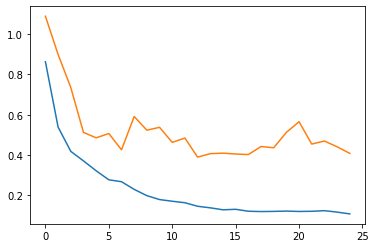

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [29]:
predicts = []
for i in dataxes:
    predict = model.predict(i)
    predicts.append(predict)

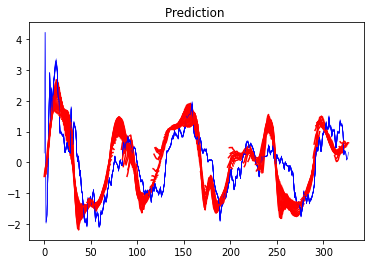

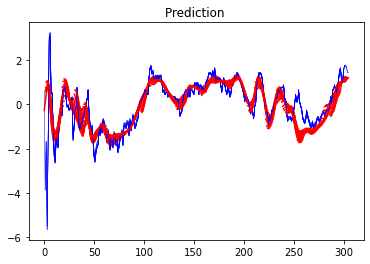

In [30]:
for j in range(len(dataxes)):
    for i in range(len(datayes[j])):
        plt.plot(range(i,i+10), datayes[j][i], c='blue', linewidth=0.5)
        plt.plot(range(i,i+10), predicts[j][i], c='red')

    #plt.plot(range(0,15), datay[19], label='true')
    #plt.plot(range(1,16), datay[20], label='true')
    #plt.plot(range(1,16), predict[20], label='predicted')
    #plt.legend()
    plt.title('Prediction ')
    #plt.savefig('images/RNN_15_ahead')
    plt.show()


In [85]:
predict[0]

array([0.76824886, 0.98426884, 1.1329707 , 0.989848  , 1.1416246 ,
       1.0954686 , 0.9367621 , 0.94854134, 0.5770784 , 0.5705154 ,
       0.5571046 , 0.36905763, 0.28623486, 0.27843568, 0.05921907],
      dtype=float32)

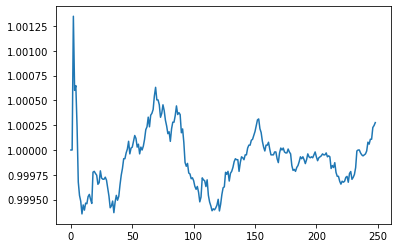

In [120]:
plt.plot(data.sma30_derivert)
#plt.plot(data.sma5_derivert)

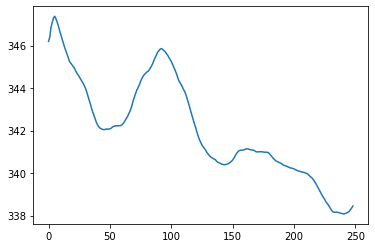

In [121]:
plt.plot(data.open_30_sma)
#plt.plot(data.sma5_derivert)

In [53]:
# Save model

#model.save('rnn_model')

INFO:tensorflow:Assets written to: rnn_model\assets


In [56]:
!dir

 Volume in drive C is Windows
 Volume Serial Number is 0223-158D

 Directory of C:\Users\Stian\Documents\School\99. Div\intradag

19.09.2020  00.30    <DIR>          .
19.09.2020  00.30    <DIR>          ..
16.08.2020  17.38    <DIR>          .idea
01.09.2020  19.48    <DIR>          .ipynb_checkpoints
24.08.2020  21.27    <DIR>          data
26.08.2020  22.16    <DIR>          history
18.09.2020  19.30    <DIR>          images
25.08.2020  13.08    <DIR>          lib
30.08.2020  10.25           514ÿ958 make_model.ipynb
19.09.2020  00.30    <DIR>          models
29.08.2020  11.29               664 README.md
19.09.2020  00.29           132ÿ506 RNN_trial.ipynb
16.08.2020  17.14         3ÿ922ÿ732 smadaytrade.ipynb
01.09.2020  20.07           775ÿ971 use_model.ipynb
17.08.2020  12.53    <DIR>          __pycache__
               5 File(s)      5ÿ346ÿ831 bytes
              10 Dir(s)  75ÿ003ÿ355ÿ136 bytes free
